In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input , Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers.embeddings import Embedding
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pickle
from keras.layers import LSTM
from keras.preprocessing.text import text_to_word_sequence
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from keras.layers.normalization import BatchNormalization
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from IPython.display import Image
from scipy.sparse import hstack
from keras.layers import Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from prettytable import PrettyTable
from keras.preprocessing import sequence
from numpy import zeros
from keras import regularizers
from keras.layers import Conv1D
from keras.initializers import he_normal
from keras import optimizers


# 1. Loading the data

In [ ]:
import pandas as pd
data =pd.read_csv("../input/preprocesseddonorchoose/preprocessed_data.csv")

In [ ]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
data.describe

<bound method NDFrame.describe of        school_state teacher_prefix project_grade_category  \
0                ca            mrs          grades_prek_2   
1                ut             ms             grades_3_5   
2                ca            mrs          grades_prek_2   
3                ga            mrs          grades_prek_2   
4                wa            mrs             grades_3_5   
...             ...            ...                    ...   
109243           hi            mrs            grades_9_12   
109244           nm             ms          grades_prek_2   
109245           il            mrs             grades_3_5   
109246           hi            mrs            grades_9_12   
109247           ca            mrs          grades_prek_2   

        teacher_number_of_previously_posted_projects  project_is_approved  \
0                                                 53                    1   
1                                                  4                    1   
2 

In [ ]:
print(data.columns)
print(data.shape)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')
(109248, 9)


In [ ]:
x = data.drop('project_is_approved',axis=1)

In [ ]:
y = data.project_is_approved.values

In [ ]:
print(x.shape,y.shape)

(109248, 8) (109248,)


# 2. Spliting data into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify = y,random_state=0)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(87398, 8) (21850, 8)
(87398,) (21850,)


In [ ]:
#class imalbalance
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
print(weights)


[3.30202509 0.58922119]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train,2)
y_test = tf.keras.utils.to_categorical(y_test,2)

In [ ]:
weights = {0:3.30202509  ,1:0.58922119}

# 3.  Preparing data for Model-1

## 3.1 Prepraing and Encoding Essay

In [ ]:
essay = data.essay.values.tolist()
num_words_in_paragraph = [len(i.split()) for i in essay]
num_of_words_in_essay = [i for j in [i.split() for i in essay] for i in j]

In [ ]:
print("The max number of words in a paragraph is : ",max(num_words_in_paragraph))
print("*"*50)
print("Total no of word eassy is : ", len(num_of_words_in_essay))
print("*"*50)
unique_words_in_essay = len(set(num_of_words_in_essay))
print("No of Unique words in essay is :", unique_words_in_essay)


The max number of words in a paragraph is :  339
**************************************************
Total no of word eassy is :  16540843
**************************************************
No of Unique words in essay is : 56381


In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizing = Tokenizer(num_words= len(num_of_words_in_essay) )
tokenizing.fit_on_texts(X_train["essay"])
word_index = tokenizing.word_index

In [ ]:
# Encode training data and testing data into sequences
Training_sequence = tokenizing.texts_to_sequences(X_train["essay"].tolist())
Testing_sequence = tokenizing.texts_to_sequences(X_test["essay"].tolist())

In [ ]:
# Get max training and testing sequence length
Train_set_max_len = max([len(x) for x in Training_sequence])
Test_set_max_len = max([len(x) for x in Testing_sequence])
print("Max length of Training sequence for Essay is :",Train_set_max_len)
print("*"*80)
print("Max length of Testing sequence for Essay is :",Test_set_max_len)

Max length of Training sequence for Essay is : 339
********************************************************************************
Max length of Testing sequence for Essay is : 330


In [ ]:
# Since There are diffrent len of squences  appling post padding;
import tensorflow as tf
max_seq_len = 340
X_train_padding = tf.keras.preprocessing.sequence.pad_sequences(Training_sequence, maxlen = max_seq_len, padding = 'post')
X_test_padding = tf.keras.preprocessing.sequence.pad_sequences(Testing_sequence, maxlen = max_seq_len, padding = 'post')
print("After Padding Shape of Training data for Eassy :", X_train_padding.shape)
print("*"*80)
print("After Padding Shape of Testing data for Eassy :", X_test_padding.shape)


After Padding Shape of Training data for Eassy : (87398, 340)
********************************************************************************
After Padding Shape of Testing data for Eassy : (21850, 340)


In [ ]:
#Using pre_trained Glove_vectors
import pickle
with open('../input/vectors/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# computing average word2vec for each review.
import numpy as np
embedding_matrix = np.zeros((len(word_index)+1,300))
for word, index in word_index.items():
  if word in glove_words:
    embedding_vector = model[word]
    embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix.shape)

(51803, 300)


## 3.2 Prepraing and Encoding Categorical Features

In [ ]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
#This code has been taken from Stackoverflow discussion.
from sklearn.preprocessing import LabelEncoder
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

### 3.2.1 School State

In [ ]:
vectorizer = LabelEncoderExt()
vectorizer.fit(X_train['school_state'].values)
school_state_vocab = len(vectorizer.classes_) 
X_train_school_state = vectorizer.transform(X_train['school_state'].values)
X_test_school_state = vectorizer.transform(X_test['school_state'].values)
embedding_size_school = min(50, (school_state_vocab)//2+1)
print(X_train_school_state.shape)
print("*"*50)
print(X_test_school_state.shape)
print("*"*50)
print("The vocabulary size : ", school_state_vocab)
print("*"*50)
print("The Embedding Size for School State will be :" ,embedding_size_school-1)
#Heuristic given by Jermey Howard of Fast.Ai is to take half the number of unique values then add one.

(87398,)
**************************************************
(21850,)
**************************************************
The vocabulary size :  52
**************************************************
The Embedding Size for School State will be : 26


### 3.2.2 Teacher Prefix

In [ ]:
vectorizer = LabelEncoderExt()
vectorizer.fit(X_train['teacher_prefix'].values)
teacher_prefix_vocab = len(vectorizer.classes_)
X_train_teacher_prefix = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix = vectorizer.transform(X_test['teacher_prefix'].values)
embedding_size_teacher_prefix = min(50,(teacher_prefix_vocab)//2+1)
print(X_train_teacher_prefix.shape)
print("*"*50)
print(X_test_teacher_prefix.shape)
print("*"*50)
print("The vocabulary size : ", teacher_prefix_vocab)
print("*"*50)
print("The Embedding Size for Teacher prefix will be :" ,embedding_size_teacher_prefix-1) 
#Heuristic given by Jermey Howard of Fast.Ai is to take half the number of unique values then add one.

(87398,)
**************************************************
(21850,)
**************************************************
The vocabulary size :  6
**************************************************
The Embedding Size for Teacher prefix will be : 3


### 3.2.3 Project_grade_category

In [ ]:
vectorizer = LabelEncoderExt()
vectorizer.fit(X_train['project_grade_category'].values)
project_grade_category_vocab = len(vectorizer.classes_)
X_train_project_grade_category = vectorizer.transform(X_train['project_grade_category'].values)
X_test_project_grade_category = vectorizer.transform(X_test['project_grade_category'].values)
embedding_size_teacher_prefix = min(50,(project_grade_category_vocab)//2+1)
print(X_train_teacher_prefix.shape)
print("*"*50)
print(X_test_teacher_prefix.shape)
print("*"*50)
print("The vocabulary size : ", teacher_prefix_vocab)
print("*"*50)
print("The Embedding Size for Project Grade Category will be :" ,embedding_size_teacher_prefix-1) 
#Heuristic given by Jermey Howard of Fast.Ai is to take half the number of unique values then add one.

(87398,)
**************************************************
(21850,)
**************************************************
The vocabulary size :  6
**************************************************
The Embedding Size for Project Grade Category will be : 2


### 3.2.4 Clean_categories

In [ ]:
vectorizer = LabelEncoderExt()
vectorizer.fit(X_train['clean_categories'].values)
clean_categories_vocab = len(vectorizer.classes_)
X_train_clean_categories = vectorizer.transform(X_train['clean_categories'].values)
X_test_clean_categories = vectorizer.transform(X_test['clean_categories'].values)
embedding_size_teacher_prefix = min(50,(clean_categories_vocab)//2+1)
print(X_train_clean_categories.shape)
print("*"*50)
print(X_test_clean_categories.shape)
print("*"*50)
print("The vocabulary size : ", clean_categories_vocab)
print("*"*50)
print("The Embedding Size for Clean Category will be :" ,embedding_size_teacher_prefix-1)
#Heuristic given by Jermey Howard of Fast.Ai is to take half the number of unique values then add one.

(87398,)
**************************************************
(21850,)
**************************************************
The vocabulary size :  52
**************************************************
The Embedding Size for Clean Category will be : 26


### 3.2.5 Clean_subcategories

In [ ]:
vectorizer = LabelEncoderExt()
vectorizer.fit(X_train['clean_subcategories'].values)
clean_subcategories_vocab = len(vectorizer.classes_)
X_train_clean_subcategories = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories = vectorizer.transform(X_test['clean_subcategories'].values)
embedding_size_teacher_prefix = min(50,(clean_subcategories_vocab)//2+1)
print(X_train_clean_categories.shape)
print("*"*50)
print(X_test_clean_categories.shape)
print("*"*50)
print("The vocabulary size : ", clean_subcategories_vocab)
print("*"*50)
print("The Embedding Size for Clean Sub Category will be:" ,embedding_size_teacher_prefix-1)
#Heuristic given by Jermey Howard of Fast.Ai is to take half the number of unique values then add one.

(87398,)
**************************************************
(21850,)
**************************************************
The vocabulary size :  394
**************************************************
The Embedding Size for Clean Sub Category will be: 49


## 3.3 Preparing and Encoding Numerical features

### 3.3.1 Price

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(data['price'].values.reshape(-1,1))
price_train = normalizer.transform(X_train['price'].values.reshape(-1,1))
price_test = normalizer.transform(X_test['price'].values.reshape(-1,1))
print(price_train.shape)
print("*"*50)
print(price_test.shape)

(87398, 1)
**************************************************
(21850, 1)


### 3.3.2 Teacher_number_of_previously_posted_projects

In [ ]:
normalizer.fit(data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
train_teacher_number_of_previously_posted_projects = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
test_teacher_number_of_previously_posted_projects = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(train_teacher_number_of_previously_posted_projects.shape)
print("*"*50)
print(test_teacher_number_of_previously_posted_projects.shape)

(87398, 1)
**************************************************
(21850, 1)


### 3.3.3 Merging Numerical features

In [ ]:
X_train_numerical = np.hstack((price_train, train_teacher_number_of_previously_posted_projects))
X_test_numerical = np.hstack((price_test, test_teacher_number_of_previously_posted_projects))
print(X_train_nummerical.shape)
print(X_test_numerical.shape)

(87398, 2)
(21850, 2)


# 4. Building Model -1

In [ ]:
tf.keras.backend.clear_session()
def model_1():
  
  # essay_input # the input shape will be the shape of the embedding matrix
  input_1 = Input(shape=(340,), name='essay_input') #Using name to map inputs while calling  model.fit()
  embd = Embedding(len(word_index)+1,300, weights=[embedding_matrix], input_length=340,trainable=False)(input_1)
  lstm_unit = LSTM(128,kernel_regularizer=regularizers.l2(0.001),return_sequences=True,
                  kernel_initializer='glorot_normal')(embd)
  flatten_1 = Flatten()(lstm_unit)


  # school_state
  input_2 = Input(shape=(1,), name='school_state')
  school_state = Embedding(output_dim=28 , input_dim=52, input_length=1)(input_2)
  flatten_2 = Flatten()(school_state)


  #teacher_prefix
  input_3 = Input(shape=(1,), name='teacher_prefix')
  teacher_prefix = Embedding(output_dim=4, input_dim=6, input_length=1)(input_3)
  flatten_3 = Flatten()(teacher_prefix)


  #clean_categories
  input_4 = Input(shape=(1,), name='clean_categories')
  clean_categories = Embedding(output_dim=28, input_dim=52, input_length=1)(input_4)
  flatten_4 = Flatten()(clean_categories)


  #clean_subcategories
  input_5 = Input(shape=(1,), name='clean_subcategories')
  clean_subcategories = Embedding(output_dim=50, input_dim=394, input_length=1)(input_5)
  flatten_5 = Flatten()(clean_subcategories)



  #project_grade_category
  input_6 = Input(shape=(1,), name='project_grade_category')
  project_grade_category = Embedding(output_dim=2, input_dim=5, input_length=1)(input_6)
  flatten_6 = Flatten()(project_grade_category)

  # numerical features
  numeric_features = Input(shape=(2,) , name="numerical_features")
  numeric_dense = Dense(32, activation='swish' , kernel_initializer='glorot_normal')(numeric_features )


  #Concating all the flatenned inputs
  concat = concatenate([flatten_1 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , numeric_dense])

  #dense-block
  dense_1 = Dense(64, activation='swish', name='dense_1',kernel_initializer='glorot_normal',
                kernel_regularizer=regularizers.l2(0.001))(concat)
  
  dense_2 = Dense(32, activation='swish', name='dense_2',kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.001))(dense_1)

  dense_3 = Dense(16, activation='swish', name='dense_3',kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.001))(dense_2)
  
  



  



  output = Dense(2, activation='softmax', name='output')(dense_3)

  model = Model(inputs=[input_1, input_2 ,input_3,input_4,
                       input_5,input_6 ,numeric_features],outputs=[output])
  return model


In [ ]:
model_1 = model_1()
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        [(None, 340)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 340, 300)     15540900    essay_input[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

## 4.1 Training Model-1

In [ ]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping
                                          
                                          #Wraps a python function into a TensorFlow op that executes it eagerly

from sklearn.metrics import roc_auc_score

def au_roc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

def train_model_1():
 

  opt = tf.keras.optimizers.Adam(0.001)
   
   
  metrics = ["acc",au_roc] 
                                                                             #using recall and Precsion 
  model_1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("/kaggle/working/model_1.h5",monitor = "val_au_roc",save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.6,mode='min', patience=3), #Reducing learing rate by factor of(0.5),
                                                                       # new_lr = lr * factor.
        CSVLogger("/kaggle/working/data.csv"),
        EarlyStopping(monitor='val_au_roc', patience=10,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]                                                                             #after 20 epochs.
  history = model_1.fit({'essay_input': X_train_padding, 'school_state': X_train_school_state, 
                         'project_grade_category': X_train_project_grade_category,
                         'clean_categories': X_train_clean_categories,
                         'clean_subcategories':X_train_clean_subcategories, 
                         'teacher_prefix':X_train_teacher_prefix,
                         'numerical_features' : X_train_numerical},y_train,
                          epochs=10, batch_size=128,verbose=1, 
                          validation_data=({'essay_input': X_test_padding, 'school_state': X_test_school_state, 
                                            'project_grade_category': X_test_project_grade_category,
                                            'clean_categories': X_test_clean_categories,
                                            'clean_subcategories':X_test_clean_subcategories, 
                                            'teacher_prefix':X_test_teacher_prefix ,
                                            'numerical_features' : X_test_numerical},y_test),
                       callbacks=callbacks,
                       class_weight = weights)
                    
  
  tf.keras.models.save_model(model_1,'/kaggle/working/final_model_1.h5')
  
  
  return history


In [ ]:
import sys
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_1 = train_model_1()

Epoch 1/10
683/683 [==============================] - 47s 63ms/step - loss: 0.9435 - acc: 0.5796 - au_roc: 0.6526 - val_loss: 0.6048 - val_acc: 0.7365 - val_au_roc: 0.7349
Epoch 2/10
683/683 [==============================] - 42s 62ms/step - loss: 0.6618 - acc: 0.7049 - au_roc: 0.7366 - val_loss: 0.6011 - val_acc: 0.7672 - val_au_roc: 0.7485
Epoch 3/10
683/683 [==============================] - 43s 62ms/step - loss: 0.6379 - acc: 0.7266 - au_roc: 0.7485 - val_loss: 0.5815 - val_acc: 0.7513 - val_au_roc: 0.7546
Epoch 4/10
683/683 [==============================] - 42s 62ms/step - loss: 0.6260 - acc: 0.7385 - au_roc: 0.7561 - val_loss: 0.6303 - val_acc: 0.7076 - val_au_roc: 0.7602
Epoch 5/10
683/683 [==============================] - 43s 63ms/step - loss: 0.6087 - acc: 0.7412 - au_roc: 0.7660 - val_loss: 0.5169 - val_acc: 0.8002 - val_au_roc: 0.7628
Epoch 6/10
683/683 [==============================] - 42s 62ms/step - loss: 0.5983 - acc: 0.7551 - au_roc: 0.7695 - val_loss: 0.5723 - val_a

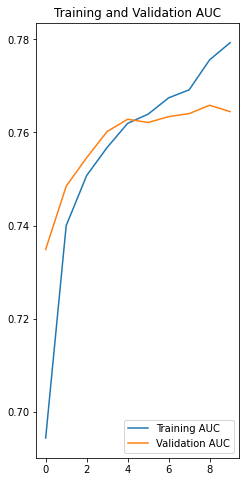

In [ ]:
import matplotlib.pyplot as plt

epochs =10
epochs_range = range(epochs)
auc = history_1.history['au_roc']
val_auc = history_1.history['val_au_roc']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')
plt.show()

# 5. Building Model-2

## 5.1 Training the TF-IDF on the Train data for Essay

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X_train["essay"])
scores = {'word': vectorizer.get_feature_names() , 'ranks': vectorizer.idf_}
scores_data = pd.DataFrame(data=scores)
print("Quantiles: 0-5-10-15-20-25-30-35-40-45-50-55-60-65-70-75-80-85-90-95-100")
print('*'*50)
print(np.percentile(scores['ranks'],np.arange(0, 100, 5)))
print('*'*50)
print(np.percentile(scores['ranks'] , 100))

Quantiles: 0-5-10-15-20-25-30-35-40-45-50-55-60-65-70-75-80-85-90-95-100
**************************************************
[ 1.00777624  6.31970072  7.61606519  8.4269954   9.12014258  9.67018892
 10.07565403 10.43232897 10.76880121 10.99194476 11.27962683 11.27962683
 11.27962683 11.68509194 11.68509194 11.68509194 11.68509194 11.68509194
 11.68509194 11.68509194]
**************************************************
11.685091939370627


In [ ]:
filter_data =   (scores_data['ranks']>=3) & (scores_data['ranks'] <=11.5)
picked_data = scores_data[filter_data]
print(picked_data.shape)

(31365, 2)


In [ ]:
filtered_data = picked_data['word'].tolist()
tokenizer = Tokenizer(num_words= len(num_of_words_in_essay) )
tokenizer.fit_on_texts(filtered_data)
filtered_essay_seq_train  = tokenizer.texts_to_sequences(X_train['essay'].values)
filtered_essay_seq_test  = tokenizer.texts_to_sequences(X_test['essay'].values)
filtered_essay_vocab_size = len(tokenizer.word_index)


In [ ]:
print("There are {} number of unique words in the entire text corpus".format(filtered_essay_vocab_size))
print('*'*50)
filtered_Train_set_max_len = max([len(x) for x in filtered_essay_seq_train])
filtered_Test_set_max_len = max([len(x) for x in filtered_essay_seq_test])
print("Max length of Training sequence for Essay is :",filtered_Train_set_max_len)
print("*"*80)
print("Max length of Testing sequence for Essay is :",filtered_Test_set_max_len)

There are 31365 number of unique words in the entire text corpus
**************************************************
Max length of Training sequence for Essay is : 230
********************************************************************************
Max length of Testing sequence for Essay is : 226


# 5.2 Padding the sequences

In [ ]:

max_seq_len = 240
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(filtered_essay_seq_train, maxlen = max_seq_len, padding = 'post')
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(filtered_essay_seq_test, maxlen = max_seq_len, padding = 'post')
print("After Padding Shape of Training data for Eassy :", X_train_pad.shape)
print("*"*80)
print("After Padding Shape of Testing data for Eassy :", X_test_pad.shape)


After Padding Shape of Training data for Eassy : (87398, 240)
********************************************************************************
After Padding Shape of Testing data for Eassy : (21850, 240)


In [ ]:
# computing word2vec embedding matrix for each review.
embedding_matrix_new = np.zeros((filtered_essay_vocab_size+1,300))
for word, index in tokenizer.word_index.items():
  if word in glove_words:
    embedding_vector = model[word]
    embedding_matrix_new[index] = embedding_vector

print(embedding_matrix_new.shape)

(31366, 300)


## Creating Model-2

In [ ]:

def model_2():
  
  # essay_input # the input shape will be the shape of the embedding matrix
  input_1 = Input(shape=(240,), name='essay_input') #Using name to map inputs while calling  model.fit()
  embd = Embedding(filtered_essay_vocab_size+1,300, weights=[embedding_matrix_new], input_length=240,trainable=False)(input_1)
  lstm_unit = LSTM(128,kernel_regularizer=regularizers.l1(0.001),return_sequences=True)(embd)
  flatten_1 = Flatten()(lstm_unit)


  # school_state
  input_2 = Input(shape=(1,), name='school_state')
  school_state = Embedding(output_dim=28 , input_dim=52, input_length=1)(input_2)
  flatten_2 = Flatten()(school_state)


  #teacher_prefix
  input_3 = Input(shape=(1,), name='teacher_prefix')
  teacher_prefix = Embedding(output_dim=4, input_dim=6, input_length=1)(input_3)
  flatten_3 = Flatten()(teacher_prefix)


  #clean_categories
  input_4 = Input(shape=(1,), name='clean_categories')
  clean_categories = Embedding(output_dim=28, input_dim=52, input_length=1)(input_4)
  flatten_4 = Flatten()(clean_categories)


  #clean_subcategories
  input_5 = Input(shape=(1,), name='clean_subcategories')
  clean_subcategories = Embedding(output_dim=50, input_dim=394, input_length=1)(input_5)
  flatten_5 = Flatten()(clean_subcategories)



  #project_grade_category
  input_6 = Input(shape=(1,), name='project_grade_category')
  project_grade_category = Embedding(output_dim=3, input_dim=5, input_length=1)(input_6)
  flatten_6 = Flatten()(project_grade_category)

  # numerical features
  numeric_features = Input(shape=(2,) , name="numerical_features")
  numeric_dense = Dense(32, activation='swish' , kernel_initializer='glorot_normal')(numeric_features )


  #Concating all the flatenned inputs
  concat = concatenate([flatten_1 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , numeric_dense])

  #dense-block
  dense_1 = Dense(64, activation='swish', name='dense_1',kernel_initializer='glorot_normal',
                kernel_regularizer=regularizers.l2(0.001))(concat)
  
  dense_2 = Dense(32, activation='swish', name='dense_2',kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.001))(dense_1)

  dense_3 = Dense(16, activation='swish', name='dense_3',kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.001))(dense_2)
  



  output = Dense(2, activation='softmax', name='output')(dense_3)

  model = Model(inputs=[input_1, input_2 ,input_3,input_4,
                       input_5,input_6 ,numeric_features],outputs=[output])
  return model


In [ ]:
model_2 = model_2()
model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 240, 300)     9409800     essay_input[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
def train_model_2():
   

  opt = tf.keras.optimizers.Adam(0.001)
    
  metrics = ["acc",au_roc] 
                                                                        
  model_2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("/kaggle/working/model_2.h5",monitor = 'val_auc',save_best_only=True),
        ReduceLROnPlateau(monitor='val_auc', factor=0.6,mode='max', patience=5), #Reducing learing rate by factor of(0.5),
                                                                       # new_lr = lr * factor.
        CSVLogger("/kaggle/working/data.csv"),
        TensorBoard(),
        EarlyStopping(monitor='val_acc', patience=10,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]                                                                             #after 20 epochs.
  history = model_2.fit({'essay_input': X_train_pad, 'school_state': X_train_school_state, 
                         'project_grade_category': X_train_project_grade_category,
                         'clean_categories': X_train_clean_categories,
                         'clean_subcategories':X_train_clean_subcategories, 
                         'teacher_prefix':X_train_teacher_prefix,
                         'numerical_features' : X_train_numerical},y_train,
                          epochs=10, batch_size=128,verbose=1, 
                          validation_data=({'essay_input': X_test_pad, 'school_state': X_test_school_state, 
                                            'project_grade_category': X_test_project_grade_category,
                                            'clean_categories': X_test_clean_categories,
                                            'clean_subcategories':X_test_clean_subcategories, 
                                            'teacher_prefix':X_test_teacher_prefix ,
                                            'numerical_features' : X_test_numerical},y_test),callbacks=callbacks)
                    
  
  tf.keras.models.save_model(model_2,'/kaggle/working/final_model_2.h5')
  
  
  return history


In [ ]:
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_2 = train_model_2()

Epoch 1/10
683/683 [==============================] - 36s 48ms/step - loss: 1.6511 - acc: 0.8420 - au_roc: 0.6549 - val_loss: 0.4396 - val_acc: 0.8486 - val_au_roc: 0.7018
Epoch 2/10
683/683 [==============================] - 31s 45ms/step - loss: 0.4402 - acc: 0.8478 - au_roc: 0.7004 - val_loss: 0.4246 - val_acc: 0.8486 - val_au_roc: 0.7134
Epoch 3/10
683/683 [==============================] - 31s 45ms/step - loss: 0.4277 - acc: 0.8459 - au_roc: 0.7165 - val_loss: 0.4193 - val_acc: 0.8486 - val_au_roc: 0.7151
Epoch 4/10
683/683 [==============================] - 30s 44ms/step - loss: 0.4185 - acc: 0.8492 - au_roc: 0.7164 - val_loss: 0.4167 - val_acc: 0.8491 - val_au_roc: 0.7206
Epoch 5/10
683/683 [==============================] - 31s 45ms/step - loss: 0.4199 - acc: 0.8483 - au_roc: 0.7229 - val_loss: 0.4166 - val_acc: 0.8486 - val_au_roc: 0.7211
Epoch 6/10
683/683 [==============================] - 31s 45ms/step - loss: 0.4174 - acc: 0.8490 - au_roc: 0.7218 - val_loss: 0.4208 - val_a

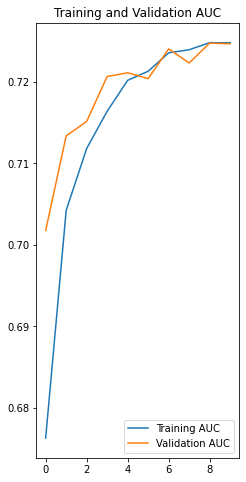

In [ ]:
import matplotlib.pyplot as plt
epochs =10
epochs_range = range(epochs)
auc = history_2.history['au_roc']
val_auc = history_2.history['val_au_roc']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')
plt.show()

# 6 Prepraing data for Model-3

## 6.1 One-hot Ecodings for Categorical features

### 6.1.1 School State

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
school_state_vocab_one_hot = len(vectorizer.vocabulary_)


X_train_school_state_hot = np.array(vectorizer.transform(X_train['school_state'].values).todense())
X_test_school_state_hot = np.array(vectorizer.transform(X_test['school_state'].values).todense())

print("X_train school_state categorical data shape : ", X_train_school_state_hot.shape)
print("**"*50)
print("X_test school_state categorical data shape : ", X_test_school_state_hot.shape)
print("**"*50)
print("The vocabulary size : ", school_state_vocab_one_hot)

X_train school_state categorical data shape :  (87398, 51)
****************************************************************************************************
X_test school_state categorical data shape :  (21850, 51)
****************************************************************************************************
The vocabulary size :  51


### 6.1.2 Teacher Prefix

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)
teacher_prefix_vocab_one_hot = len(vectorizer.vocabulary_)


X_train_teacher_prefix_hot = np.array(vectorizer.transform(X_train['teacher_prefix'].values).todense())
X_test_teacher_prefix_hot = np.array(vectorizer.transform(X_test['teacher_prefix'].values).todense())

print("X_train_teacher_prefix_hot categorical data shape : ", X_train_teacher_prefix_hot.shape)
print("**"*50)
print("X_train_teacher_prefix_hot categorical data shape : ", X_test_teacher_prefix_hot.shape)
print("**"*50)
print("The vocabulary size  : ", teacher_prefix_vocab_one_hot)

X_train_teacher_prefix_hot categorical data shape :  (87398, 5)
****************************************************************************************************
X_train_teacher_prefix_hot categorical data shape :  (21850, 5)
****************************************************************************************************
The vocabulary size  :  5


### 6.1.3 Project grade category

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)
project_grade_category_one_hot_vocab = len(vectorizer.vocabulary_)


X_train_project_grade_category_hot = np.array(vectorizer.transform(X_train['project_grade_category'].values).todense())
X_test_project_grade_category_hot = np.array(vectorizer.transform(X_test['project_grade_category'].values).todense())

print("X_train_project_grade_category_hot categorical data shape : ", X_train_project_grade_category_hot.shape)
print("**"*50)
print("X_test_project_grade_category_hot categorical data shape : ", X_test_project_grade_category_hot.shape)
print("**"*50)
print("The vocabulary size  : ", project_grade_category_one_hot_vocab)

X_train_project_grade_category_hot categorical data shape :  (87398, 4)
****************************************************************************************************
X_test_project_grade_category_hot categorical data shape :  (21850, 4)
****************************************************************************************************
The vocabulary size  :  4


### 6.1.4 Clean_categories

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)
clean_categories_one_hot_vocab = len(vectorizer.vocabulary_)


X_train_clean_categories_hot = np.array(vectorizer.transform(X_train['clean_categories'].values).todense())
X_test_clean_categories_hot = np.array(vectorizer.transform(X_test['clean_categories'].values).todense())

print("X_train_clean_categories_hot categorical data shape : ", X_train_clean_categories_hot.shape)
print("**"*50)
print("X_test_clean_categories_hot categorical data shape : ", X_test_clean_categories_hot.shape)
print("**"*50)
print("The vocabulary size  : ", clean_categories_one_hot_vocab)

X_train_clean_categories_hot categorical data shape :  (87398, 9)
****************************************************************************************************
X_test_clean_categories_hot categorical data shape :  (21850, 9)
****************************************************************************************************
The vocabulary size  :  9


### 6.1.5 Clean sub_categories

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)
clean_subcategories_one_hot_vocab = len(vectorizer.vocabulary_)


X_train_clean_subcategories_hot = np.array(vectorizer.transform(X_train['clean_subcategories'].values).todense())
X_test_clean_subcategories_hot = np.array(vectorizer.transform(X_test['clean_subcategories'].values).todense())

print("X_train_clean_subcategories_hot categorical data shape : ", X_train_clean_subcategories_hot.shape)
print("**"*50)
print("X_test_clean_subcategories_hot categorical data shape : ", X_test_clean_subcategories_hot.shape)
print("**"*50)
print("The vocabulary size  : ", clean_subcategories_one_hot_vocab)

X_train_clean_subcategories_hot categorical data shape :  (87398, 30)
****************************************************************************************************
X_test_clean_subcategories_hot categorical data shape :  (21850, 30)
****************************************************************************************************
The vocabulary size  :  30


In [ ]:
X_train_non_text_features = np.hstack((X_train_school_state_hot, X_train_teacher_prefix_hot, 
                                    X_train_project_grade_category_hot, X_train_clean_categories_hot, 
                                    X_train_clean_subcategories_hot, X_train_numerical))

In [ ]:
X_test_non_text_features = np.hstack((X_test_school_state_hot, X_test_teacher_prefix_hot, 
                                    X_test_project_grade_category_hot, X_test_clean_categories_hot, 
                                    X_test_clean_subcategories_hot, X_test_numerical))

In [ ]:
print("Non-text features shape Train data : ", X_train_non_text_features.shape)
print("**"*50)
print("Non-text features shape Test data : ", X_test_non_text_features.shape)


Non-text features shape Train data :  (87398, 101)
****************************************************************************************************
Non-text features shape Test data :  (21850, 101)


In [ ]:
X_train_new = X_train_non_text_features.reshape(X_train_non_text_features.shape[0], 101, 1)
X_test_new = X_test_non_text_features.reshape(X_test_non_text_features.shape[0],101,1)
print("Non-text features shape Train data after reshaping : ", X_train_new.shape)
print("**"*50)
print("Non-text features shape Test data after reshaping: ", X_test_new.shape)


Non-text features shape Train data after reshaping :  (87398, 101, 1)
****************************************************************************************************
Non-text features shape Test data after reshaping:  (21850, 101, 1)


In [ ]:
from keras.layers import Convolution1D

def model_3():
  
  # essay_input # the input shape will be the shape of the embedding matrix
  input_1 = Input(shape=(340,), name='essay_input') #Using name to map inputs while calling  model.fit()
  embd = Embedding(len(word_index)+1,300, weights=[embedding_matrix], input_length=340,trainable=False)(input_1)
  lstm_unit = LSTM(128,kernel_regularizer=regularizers.l2(0.001),return_sequences=True,
                  kernel_initializer='glorot_normal')(embd)
  flatten_1 = Flatten()(lstm_unit)


  conv_input = Input(shape=(101, 1),name = 'conv_input')

  # Creating the 1st convolution layer
  conv_1 = Convolution1D(filters = 512, kernel_size = 3, strides = 1, padding = 'valid', 
                       activation = 'swish', kernel_regularizer=regularizers.l2(0.001),
                       kernel_initializer = 'glorot_normal')(conv_input)
  
  # Creating the 2nd convolution layer 
  conv_2 = Convolution1D(filters = 128, kernel_size = 3, strides = 1, padding = 'valid', 
                       activation = 'swish',kernel_regularizer=regularizers.l2(0.001),
                       kernel_initializer = 'glorot_normal')(conv_1)

  # Flattening the data
  convolution_flatten = Flatten()(conv_2)


  #Concating all the flatenned inputs
  concat = concatenate([flatten_1 , convolution_flatten])

  #dense-block
  dense_1 = Dense(64, activation='swish', name='dense_1',kernel_initializer='glorot_normal',
                kernel_regularizer=regularizers.l2(0.001))(concat)
  
  dense_2 = Dense(32, activation='swish', name='dense_2',kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.001))(dense_1)

  dense_3 = Dense(16, activation='swish', name='dense_3',kernel_initializer='glorot_normal',
                 kernel_regularizer=regularizers.l2(0.001))(dense_2)
  


  output = Dense(2, activation='softmax', name='output')(dense_3)

  model = Model(inputs=[input_1,conv_input],outputs=[output])
  return model


In [ ]:
model_3 = model_3()
model_3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        [(None, 340)]        0                                            
__________________________________________________________________________________________________
conv_input (InputLayer)         [(None, 101, 1)]     0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 340, 300)     15540900    essay_input[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 99, 512)      2048        conv_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
from sklearn.metrics import roc_auc_score #Wraps a python function into a TensorFlow op that executes it eagerly
def au_roc(y_true, y_pred):               #https://www.tensorflow.org/api_docs/python/tf/py_function
  try:                                    #https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
      return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
  except ValueError:
    pass

def train_model_3():

  opt = tf.keras.optimizers.Adam(0.001)
    
    
  metrics = ["acc",au_roc] 
                                                                       
  model_3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("/kaggle/working/model_3.h5",monitor = 'val_loss',save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.6,mode='min', patience=3), #Reducing learing rate by factor of(0.6),
                                                                       # new_lr = lr * factor.
        CSVLogger("/kaggle/working/data.csv"),
        EarlyStopping(monitor='val_loss', patience=10,mode= 'min',restore_best_weights=True) #stop traing is val_loss does not change
    ]                                                                             #after 20 epochs.
  history = model_3.fit({'essay_input': X_train_padding, 'conv_input':X_train_new },y_train,
                          epochs=10, batch_size=128,verbose=1, 
                          validation_data=({'essay_input': X_test_padding,'conv_input':X_test_new},y_test),
                          callbacks=callbacks,class_weight = weights)
                    
  
  tf.keras.models.save_model(model_3,'/kaggle/working/final_model_3.h5')
  
  
  return history


In [ ]:
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_3 = train_model_3()

Epoch 1/10
683/683 [==============================] - 48s 67ms/step - loss: 0.8668 - acc: 0.6511 - au_roc: 0.6705 - val_loss: 0.5845 - val_acc: 0.7676 - val_au_roc: 0.7419
Epoch 2/10
683/683 [==============================] - 44s 65ms/step - loss: 0.6476 - acc: 0.7210 - au_roc: 0.7374 - val_loss: 0.5689 - val_acc: 0.7787 - val_au_roc: 0.7482
Epoch 3/10
683/683 [==============================] - 44s 65ms/step - loss: 0.6276 - acc: 0.7271 - au_roc: 0.7484 - val_loss: 0.6209 - val_acc: 0.7595 - val_au_roc: 0.7541
Epoch 4/10
683/683 [==============================] - 44s 65ms/step - loss: 0.6134 - acc: 0.7436 - au_roc: 0.7581 - val_loss: 0.6048 - val_acc: 0.7685 - val_au_roc: 0.7589
Epoch 5/10
683/683 [==============================] - 44s 65ms/step - loss: 0.6157 - acc: 0.7424 - au_roc: 0.7550 - val_loss: 0.6234 - val_acc: 0.7224 - val_au_roc: 0.7590
Epoch 6/10
683/683 [==============================] - 45s 66ms/step - loss: 0.6027 - acc: 0.7356 - au_roc: 0.7660 - val_loss: 0.5407 - val_a

In [ ]:
from prettytable import PrettyTable
myTable = PrettyTable(["Model", "Accuracy","Validation Accuracy","AUC", "Validation AUC"])
  
# Add rows
myTable.add_row(["Model-1", "75.70", "74.25", "77.87",'76.58'])
myTable.add_row(["Model-2", "85.27", "85.06", "72.25","72.46"])
myTable.add_row(["Model-3", "75.44", "75.91", "78.07",'76.55'])

  
print(myTable)

+---------+----------+---------------------+-------+----------------+
|  Model  | Accuracy | Validation Accuracy |  AUC  | Validation AUC |
+---------+----------+---------------------+-------+----------------+
| Model-1 |  75.70   |        74.25        | 77.87 |     76.58      |
| Model-2 |  85.27   |        85.06        | 72.25 |     72.46      |
| Model-3 |  75.44   |        75.91        | 78.07 |     76.55      |
+---------+----------+---------------------+-------+----------------+
